# Pontificia Universidad Católica del Perú
# Ideentificación del perfil de usuarios con riesgo de incumplimiento crediticio en Lending Club

## Curso: Aprendizaje Automático: Teoria y Aplicaciones

### Integrantes: 
#### ● Lara Ávila César [https://github.com/C-Lara/ML-Tareas/tree/master/Proyecto](https://github.com/C-Lara/ML-Tareas/tree/master/Proyecto)
● Zevallos Sulca Luis.     ● Salazar Campos Juan Orlando.     ● Salazar Torres Helen

#### ●  Caso: 

[Lending Club](https://www.lendingclub.com/), que es una compañía de préstamos entre usuarios, que combina prestatarios con inversores a través de una plataforma en línea  con sede en los Estados Unidos, en la cual los inversionistas proporcionan fondos para potenciales prestatarios obteniendo ganancias dependiendo del riesgo que asumen (puntaje de crédito de los prestatarios). Los prestatarios reciben el monto total del préstamo emitido menos un monto por comisión del servicio, que se paga a la empresa. Los inversionistas compran notas respaldadas por los préstamos personales y pagan a Lending Club una tarifa por el servicio. La compañía comparte información sobre todos los préstamos emitidos a través de su plataforma durante ciertos períodos de tiempos.

El Lending Club trabaja de la siguiente manera:

* Los prestatarios solicitan préstamos.
* Los inversores abren una cuenta
* Los prestatarios reciben fondos
* Los inversores crean una cartera de clientes
* Los prestatarios reembolsan automáticamente sus préstamos
* Los inversores ganan y reinvierten.

### Preprocesamiento de datos


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

####  Leyendo los datos desde un archivo

In [2]:
datos = pd.read_csv("loan.csv", low_memory=False)

In [3]:
# df_loan.head()
# df_loan.info()

#### Removemos filas y columnas con muchos NA

* Removemos columnas cuyo número de NA es mayor que el 70%
* Removemos las filas cuyo número de  NA es mayor que 30


In [4]:
razon_de_nulos = datos.isnull().sum(axis = 0).sort_values(ascending = False)/float((len(datos)))
razon_de_nulos[razon_de_nulos > 0.7]

dti_joint                      0.999426
verification_status_joint      0.999424
annual_inc_joint               0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
all_util                       0.975916
max_bal_bc                     0.975916
open_rv_24m                    0.975916
open_rv_12m                    0.975916
total_cu_tl                    0.975916
total_bal_il                   0.975916
open_il_24m                    0.975916
open_il_12m                    0.975916
open_il_6m                     0.975916
open_acc_6m                    0.975916
inq_fi                         0.975916
inq_last_12m                   0.975916
desc                           0.857977
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
dtype: float64

In [5]:
datos.drop(razon_de_nulos[razon_de_nulos>0.7].index,axis = 1,inplace=True)

In [6]:
datos.dropna(axis = 0,thresh=30,inplace = True)

#### Encontramos  las columnas que tienen muy pocos/demasiados datos únicos

Inspeccionamos estas columnas para decidir si eliminarlas o no.

In [7]:
tasa_unica = datos.apply(lambda x: len(pd.unique(x)),axis = 0).sort_values(ascending = False)

In [8]:
tasa_unica

id                            887379
url                           887379
member_id                     887379
total_pymnt                   506726
total_pymnt_inv               506616
tot_cur_bal                   327343
total_rec_int                 324635
emp_title                     299272
out_prncp_inv                 266244
total_rec_prncp               260227
out_prncp                     248332
last_pymnt_amnt               232451
revol_bal                      73740
installment                    68711
title                          63145
annual_inc                     49385
recoveries                     23055
total_rev_hi_lim               21252
collection_recovery_fee        20708
tot_coll_amt                   10326
funded_amnt_inv                 9856
total_rec_late_fee              6181
dti                             4086
funded_amnt                     1372
loan_amnt                       1372
revol_util                      1357
zip_code                         935
e

In [9]:
# Imprimimos las columnas que tienen pocos elementos
def analisis_columna(x,dataframe = datos): 
    print(dataframe[x].value_counts(),"\n",dataframe[x].value_counts()/len(dataframe[x]))

analisis_columna("pymnt_plan")
analisis_columna("initial_list_status")
analisis_columna("application_type")
analisis_columna("acc_now_delinq")

n    887369
y        10
Name: pymnt_plan, dtype: int64 
 n    0.999989
y    0.000011
Name: pymnt_plan, dtype: float64
f    456848
w    430531
Name: initial_list_status, dtype: int64 
 f    0.514829
w    0.485171
Name: initial_list_status, dtype: float64
INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64 
 INDIVIDUAL    0.999424
JOINT         0.000576
Name: application_type, dtype: float64
0.0     883236
1.0       3866
2.0        208
3.0         28
4.0          7
5.0          3
6.0          1
14.0         1
Name: acc_now_delinq, dtype: int64 
 0.0     0.995331
1.0     0.004357
2.0     0.000234
3.0     0.000032
4.0     0.000008
5.0     0.000003
6.0     0.000001
14.0    0.000001
Name: acc_now_delinq, dtype: float64


#### Eliminamos algunas columnas

* Necesitamos eliminar id, url, member_id porque estos tres son 100% únicos
* policy_code solo tiene un valor
* payment_plan, application_type, acc_now_delinq son altamente desequilibrados (más del 90% son de un solo valor)
* mp_title, zip_code, title  no son tan importantes para analizar.

In [10]:
elimina_columnas = ["policy_code", "pymnt_plan", "url", "id", "member_id", "application_type", "acc_now_delinq", "emp_title",
               "zip_code", "title"]
datos.drop(elimina_columnas, axis=1, inplace=True)

#####  Cambiamos  el formato de algunas columnas

Cambiamos  el valor de algunas columnas a número para un análisis posterior.

In [11]:
datos["term"] = datos["term"].str.split(" ").str[1]

In [12]:
datos["emp_length"] = datos["emp_length"].str.extract("(\d+)", expand =False).map(float)
datos["emp_length"] = datos["emp_length"].fillna(datos.emp_length.median())


In [13]:
# transformamos datos de tiempo a periodos 
columna_fechas = datos.dtypes[datos.dtypes == "datetime64[ns]"].index
for d in columna_fechas:
    datos[d] = datos[d].dt.to_period["M"]

#### Transformación de  algunas columnas que son muy sesgadas

Más de la mitad de las filas en estas columnas están en un valor, por lo que las transformamos en variables categóricas.
 
 * delinq_2yrs: 80% son 0
 * inq_last_6mths:56% son 0
 * pub_rec:84% son 0


In [14]:
analisis_columna("delinq_2yrs")
analisis_columna("inq_last_6mths")
analisis_columna("pub_rec")

0.0     716961
1.0     113224
2.0      33551
3.0      11977
4.0       5327
5.0       2711
6.0       1471
7.0        784
8.0        461
9.0        284
10.0       192
11.0       121
12.0        89
13.0        64
14.0        45
15.0        28
16.0        17
18.0        11
17.0        10
19.0         8
22.0         3
21.0         2
26.0         2
20.0         2
30.0         1
39.0         1
27.0         1
29.0         1
24.0         1
Name: delinq_2yrs, dtype: int64 
 0.0     0.807954
1.0     0.127594
2.0     0.037809
3.0     0.013497
4.0     0.006003
5.0     0.003055
6.0     0.001658
7.0     0.000884
8.0     0.000520
9.0     0.000320
10.0    0.000216
11.0    0.000136
12.0    0.000100
13.0    0.000072
14.0    0.000051
15.0    0.000032
16.0    0.000019
18.0    0.000012
17.0    0.000011
19.0    0.000009
22.0    0.000003
21.0    0.000002
26.0    0.000002
20.0    0.000002
30.0    0.000001
39.0    0.000001
27.0    0.000001
29.0    0.000001
24.0    0.000001
Name: delinq_2yrs, dtype: float64
0.0 

In [15]:
# 80% son 0
datos["delinq_2yrs_cat"] = 0
datos.loc[datos["delinq_2yrs"] > 0, "delinq_2yrs_cat"] = 1

In [16]:
# 56% son 0
datos["inq_last_6mths_cat"] = 0
datos.loc[datos["inq_last_6mths"]>0 ,"inq_last_6mths_cat"] = 1

In [17]:
# 84% son 0
datos["pub_rec_cat"] = 0
datos.loc[datos["pub_rec"]>0,"pub_rec_cat"] = 1

####  Columnas nuevas basadas en el cálculo de variables antiguas

* funded_amnt es la cantidad total  comprometida con ese préstamo en ese momento.
* funded_amnt_inv es la cantidad total comprometida por los inversores para ese préstamo en ese momento.

Cuando no son iguales (el inversor paga menos de lo esperado), marcamos como menos.

* open_acc es la cantidad de líneas de crédito abiertas en el archivo de crédito del prestatario.
* total_acc es el número total de líneas de crédito actualmente en el archivo de crédito del prestatario
* acc_ratio significa cuántos préstamos tiene el solicitante ahora.

In [18]:
datos['acc_ratio'] = datos.open_acc / datos.total_acc

In [19]:
datos['amt_diferencia'] = 'igual'
datos.loc[(datos['funded_amnt'] - datos['funded_amnt_inv']) > 0,'amt_diferencia'] = 'menos'

In [20]:
caracteristicas = ['loan_amnt', 'amt_diferencia', 'term', 
            'installment', 'grade','emp_length',
            'home_ownership', 'annual_inc','verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'initial_list_status',  
            'loan_status'
           ]

#### Transformamos loan_status


In [21]:
datos.groupby("loan_status").size().sort_values(ascending=False)/len(datos)*100

loan_status
Current                                                67.815330
Fully Paid                                             23.408600
Charged Off                                             5.099061
Late (31-120 days)                                      1.306206
Issued                                                  0.953369
In Grace Period                                         0.704659
Late (16-30 days)                                       0.265614
Does not meet the credit policy. Status:Fully Paid      0.224031
Default                                                 0.137371
Does not meet the credit policy. Status:Charged Off     0.085758
dtype: float64

In [22]:
X_l = datos.loc[datos.loan_status != "Current",caracteristicas] 

In [23]:
mascara_N = (X_l.loan_status == 'Charged Off')
X_l['objetivo'] = 0
X_l.loc[mascara_N,'objetivo'] = 1

#### Codificación One-Hot en características categóricas

In [24]:
caracteristicas_categoricas = ['term','amt_diferencia', 'grade', 'home_ownership', 'verification_status', 'purpose', 'delinq_2yrs_cat', 
                'inq_last_6mths_cat', 'pub_rec_cat', 'initial_list_status',]
X_l.dropna(axis=0, how = 'any', inplace = True)

In [25]:
X = pd.get_dummies(X_l[X_l.columns[:-2]], columns=caracteristicas_categoricas).astype(float)

* Definimos como objetivo y
* Train test split
* Estandarizamos X_train con fit_transform, X_test con transform.


In [26]:
y = X_l['objetivo']

In [27]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=0)

In [28]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train_raw)
X_test = stdsc.transform(X_test_raw)

Con este   paso, tenemos X_train, X_test, y_train, y_test para seguir con los siguientes pasos.

### Entrenamiento, prueba y evaluación de modelos

#### Clasificadores de Scikit-learn

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


#### Conjunto de modelos 

Compararemos los modelos basados en los conjuntos de modelos.

In [35]:
comparacion_distintos_modelos = {
    "Random Forest":RandomForestClassifier(random_state=0,n_estimators=10),
    "Regresion_logistica":LogisticRegression(random_state=0),
    "Arbol de decision":DecisionTreeClassifier(random_state=0),
    #"SVM":SVC(random_state=0,probability=True) 
}


#### Función de entrenamiento de modelo

In [36]:
def modelo_entrenamiento(model_dict,X_train,y_train):
    for model in model_dict:
        print("Entrenamiento:",model)
        model_dict[model].fit(X_train,y_train)
    return model_dict

#### Función de evaluación de modelo

In [37]:
from sklearn import metrics
def modelo_evaluacion(clf_name,clf,X_test,y_test):
    print("Evaluando:",clf_name)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:,1]
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
    report = pd.Series({
        "modelo":clf_name,
        "precision":metrics.precision_score(y_test, y_pred),
        "exactitud":metrics.recall_score(y_test, y_pred),
        "f1":metrics.f1_score(y_test, y_pred),
        'roc_auc' : metrics.roc_auc_score(y_test, y_score)
    })
    # Dibujando ROC 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
    plt.figure(1, figsize=(6,6))
    plt.xlabel('Tasa de falso positivo')
    plt.ylabel('Tasa de verdadero positivo')
    plt.plot(fpr, tpr,label=clf_name)
    plt.plot([0,1],[0,1], color = 'black')
    plt.legend()
    return report,confusion_matrix


In [44]:
def modelo_eval_entrenamiento(model_dict,X_train,y_train,X_test,y_test):
    cols = ['modelo', 'roc_auc', 'precision', 'exactitud','f1']
    modelo_reporte = pd.DataFrame(columns = cols)
    cm_dict = {}
    model_dict = modelo_entrenamiento(model_dict,X_train,y_train)
    for model in model_dict:
        report,confusion_matrix = modelo_evaluacion(model,model_dict[model],X_test,y_test)
        modelo_reporte = modelo_reporte.append(report,ignore_index=True)
        cm_dict[model] = confusion_matrix
    return modelo_reporte,cm_dict


#### Función de visualización

In [45]:
def dibujo_func(df,col_name):
    df.set_index("modelo").loc[:,col_name].plot(kind='bar', stacked=True, sort_columns=True, figsize = (16,10))
    plt.title(col_name)
    plt.show()

En nuestros datos, aproximadamente el 84% (1- sum(y_train)/len(y_train) = 0.8422603414724436) de los solicitantes pagarán el préstamo a tiempo. Lo que significa que, incluso si aprobamos toda la solicitudes de los que piden préstamis, el 84% se pagará a tiempo. Sin embargo, los préstamos incobrables pueden ser más perjudiciales para la institución financiera. En esta situación, Falso negativo significa no identificar un préstamo incobrable. Entonces, deberíamos tratar de mejorar la exactitud para encontrar más préstamos incobrables.

Entrenamiento: Random Forest
Entrenamiento: Regresion_logistica
Entrenamiento: Arbol de decision
Evaluando: Random Forest
Evaluando: Regresion_logistica
Evaluando: Arbol de decision


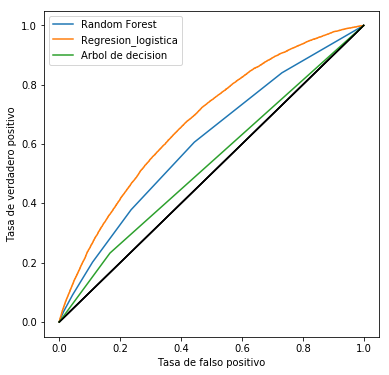

In [46]:
modelo_reporte,cm_dict = modelo_eval_entrenamiento(comparacion_distintos_modelos,X_train,y_train,X_test,y_test)



In [47]:
cm_dict

{'Arbol de decision': Predicted      0      1
 True                   
 0          59975  11981
 1          10528   3188, 'Random Forest': Predicted      0     1
 True                  
 0          70902  1054
 1          13220   496, 'Regresion_logistica': Predicted      0   1
 True                
 0          71940  16
 1          13693  23}

#### Corriendo modelos con datos balanceados

Esta parte de código está basado en el trabajo de  Liwei Zhu,Wenye Ouyang,Xiaochi Li.

Ellos utilizan conda install -c glemaitre imbalanced-learn y la técnica [SMOTE-Oversampling and undersampling in data analysis](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)( Synthetic Minority Over-sampling Technique).

In [49]:
from imblearn.over_sampling import SMOTE
index_split = int(len(X)*0.7) #30% prueba

X_train_bal, y_train_bal = SMOTE(random_state=0).fit_sample(X_train,y_train)
X_test_bal, y_test_bal = X_test, y_test

In [50]:
len(X_train_bal)

336734

In [51]:
len(X_train)

199899

In [52]:
sum(y_train_bal)/len(y_train_bal)

0.5

Antes de equilibrar los datos, solo el 15% son préstamos incobrables. Lo cual dañará el rendimiento del modelo. Después de equilibrar los datos con SMOTE, el 50% son malos préstamos.

In [53]:
sum(y_train)/len(y_train)

0.15773965852755642

In [54]:
sum(y_train_bal)/len(y_train_bal)

0.5

Entrenamiento: Random Forest
Entrenamiento: Regresion_logistica
Entrenamiento: Arbol de decision
Evaluando: Random Forest
Evaluando: Regresion_logistica
Evaluando: Arbol de decision


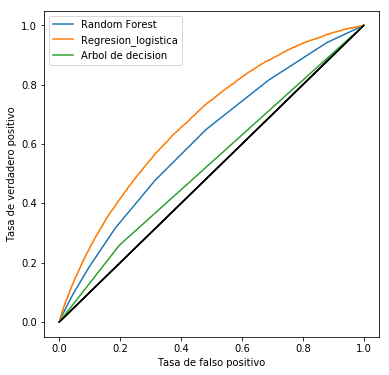

In [55]:
modelo_reporte_bal,cm_dict_bal = modelo_eval_entrenamiento(comparacion_distintos_modelos,
                                                           X_train_bal,y_train_bal,X_test_bal,y_test_bal)

In [56]:
cm_dict_bal

{'Arbol de decision': Predicted      0      1
 True                   
 0          57748  14208
 1          10165   3551, 'Random Forest': Predicted      0     1
 True                  
 0          64855  7101
 1          11160  2556, 'Regresion_logistica': Predicted      0      1
 True                   
 0          43863  28093
 1           4847   8869}

### Comparando conjuntos de modelos utilizando datos equilibrados  y desequilibrados

In [58]:
modelo_reporte

,modelo,roc_auc,precision,exactitud,f1
0,Random Forest,0.606063,0.320000,0.036162,0.064981
1,Regresion_logistica,0.677632,0.589744,0.001677,0.003344
2,Arbol de decision,0.532962,0.210165,0.232429,0.220737


In [60]:
modelo_reporte_bal

,modelo,roc_auc,precision,exactitud,f1
0,Random Forest,0.613564,0.264678,0.186352,0.218714
1,Regresion_logistica,0.677789,0.239949,0.646617,0.350014
2,Arbol de decision,0.530720,0.199955,0.258895,0.225639


### Conclusiones 

En este cuaderno inicial, parte del proyecto de 	análisis del conjunto de datos de Lending Club se centró en la construcción de diferentes modelos de aprendizaje automático y en la evaluación del rendimiento de bosques aleatorios, árboles de decisiones y la regresión logística con datos de entrenamiento de distintas variables del conjunto de datos.
 
Descubrimos que si sobremuestramos una determinada clase mediante la técnica de SMOTE en el conjunto de entrenamiento, la puntuación de recuperación mejora para cada modelo, especialmente en la regresión logística. El puntaje de recuperación indica que la regresión logística puede clasificar al 65% de los solicitantes que incumplirán los pagos.
Además del alto puntaje de recuperación después de usar datos balanceados, muestra que la regresión logística tiene otros beneficios, que para determinadas variables, los bosques aleatorios presentan una mejor alternativa como indica el artículo de  M. Malekipirbazari y V. Aksakalli, "Risk assessment in social lending via random forests".